# TWAMP EXPERIMENTS

**Done by:** Tim Josefsson, Johan Gille, Jimmy Helmersson, Linus Hedberg, Tugce Dilan

*Computer Networks III - Uppsala University - Fall 2015*

*Latest Revision: 06/06/2016*

## Code for plotting and experiments

This section contains the code used to create plots and to convert received values from the experiments. This is of no particular interest unless you are interested in seeing how to create plots using Python.

In [2]:
#!/usr/bin/env python
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from collections import defaultdict
import csv

## Defines
clock_second = 128
volt_usage = 3
r_timer = 32768
 
# Main core
standby_state = 0.5 * pow(10,-6)
active_state = 8 * pow(10,-3) # this value is to be less than 10, probably in the range of 5-10
 
# Radio stuff
rx_state = 18.8 * pow(10,-3)
tx_state = 17.4 * pow(10,-3)

In [3]:
def convert_mA(values):
    out_values = []
    for value in values:
        value = ((value/1000.0)/volt_usage)*1000
        out_values.append(value)
    return out_values

In [4]:
# for P lines
#0-> str,
#1 -> clock_time(),2-> P, 3->rimeaddr_node_addr.u8[0],rimeaddr_node_addr.u8[1], 4-> seqno,
#5 -> all_cpu,6-> all_lpm,7-> all_transmit,8-> all_listen,9-> all_idle_transmit,10-> all_idle_listen,
#11->cpu,12-> lpm,13-> transmit,14-> listen, 15 ->idle_transmit, 16 -> idle_listen, [RADIO STATISTICS...]

def totalConsumption(filelist):
    tests = 0
    cpu,lpm,tx,rx = [],[],[],[]
    for name in filelist:
        sum_cpu, sum_lpm, sum_tx, sum_rx = 0,0,0,0
        with open(name, 'rb') as f:
            reader = csv.reader(f,delimiter=' ')
            flag = 0
            for row in reader:
                if flag > 0:
                    if row[2] is 'P': 
                        sum_cpu += (int(row[11])*(active_state*volt_usage))/r_timer
                        sum_lpm += (int(row[12])*(standby_state*volt_usage))/r_timer
                        sum_tx+= (int(row[13])*(active_state+tx_state)*volt_usage)/r_timer
                        sum_rx += (int(row[14])*(active_state+rx_state)*volt_usage)/r_timer
                flag += 1
        cpu.append(sum_cpu)
        lpm.append(sum_lpm)
        tx.append(sum_tx)
        rx.append(sum_rx)
    return cpu, lpm, tx, rx

In [18]:
# for P lines
#0-> str,
#1 -> clock_time(),2-> P, 3->rimeaddr_node_addr.u8[0],rimeaddr_node_addr.u8[1], 4-> seqno,
#5 -> all_cpu,6-> all_lpm,7-> all_transmit,8-> all_listen,9-> all_idle_transmit,10-> all_idle_listen,
#11->cpu,12-> lpm,13-> transmit,14-> listen, 15 ->idle_transmit, 16 -> idle_listen, [RADIO STATISTICS...]

def totalConsumptionNew(filelist):
    test = 0
    cpu,lpm,tx,rx,tests = [],[],[],[],[]
    std_cpu,std_lpm,std_tx,std_rx = [],[],[],[]
    for name in filelist:
        temp_cpu, temp_lpm, temp_tx, temp_rx = 0,0,0,0
        sum_cpu, sum_lpm, sum_tx, sum_rx = [],[],[],[]
        with open(name, 'rb') as f:
            reader = csv.reader(f,delimiter=' ')
            flag = 0
            for row in reader:
                if row[2] is 'P': 
                    if flag != 0:
                        temp_cpu += ((int(row[11])*(active_state*volt_usage))/r_timer)
                        temp_lpm += ((int(row[12])*(standby_state*volt_usage))/r_timer)
                        temp_tx += ((int(row[13])*(active_state+tx_state)*volt_usage)/r_timer)
                        temp_rx += ((int(row[14])*(active_state+rx_state)*volt_usage)/r_timer)
                    flag = 1
                if row[2] is 'R':
                    sum_cpu.append(temp_cpu)
                    sum_lpm.append(temp_lpm)
                    sum_tx.append(temp_tx)
                    sum_rx.append(temp_rx)
                    temp_cpu, temp_lpm, temp_tx, temp_rx = 0,0,0,0
                    test += 1
                    flag = 0
                if row[2] is 'N':
                    mcpu,mlpm,mtx,mrx = sum(sum_cpu)/test,sum(sum_lpm)/test,sum(sum_tx)/test \
                                        ,sum(sum_rx)/test
                    cpu.append(mcpu)
                    lpm.append(mlpm)
                    tx.append(mtx)
                    rx.append(mrx)
                    tests.append(test)
                    
                    var_cpu = sum([pow(x-mcpu,2) for x in sum_cpu])/test
                    var_lpm = sum([pow(x-mlpm,2) for x in sum_lpm])/test
                    var_tx = sum([pow(x-mtx,2) for x in sum_tx])/test
                    var_rx = sum([pow(x-mrx,2) for x in sum_rx])/test
                    
                    std_cpu.append(math.sqrt(var_cpu))
                    std_lpm.append(math.sqrt(var_lpm))
                    std_tx.append(math.sqrt(var_tx))
                    std_rx.append(math.sqrt(var_rx))
                    
                    sum_cpu, sum_lpm, sum_tx, sum_rx = [],[],[],[]
                    test = 0
                    flag = 0
    return cpu,lpm,tx,rx,std_cpu,std_lpm,std_tx,std_rx,tests

In [6]:
def getMean(values,tests):
    output = []
    temp,i = 0,1
    for value in values:
        if i < tests:
            temp += value
            i += 1
        else:
            temp += value
            temp = temp*1.0/tests
            output.append(temp)
            temp = 0
            i = 1
    return output

In [7]:
def getStd(values, means, tests):
    output = []
    temp,i,k = 0,1,0
    for value in values:
        if i < tests:
            temp += pow((value - means[k]),2)
            i += 1
        else:
            temp += pow((value - means[k]),2)
            temp = temp*1.0/tests
            temp = math.sqrt(temp)
            output.append(temp)
            temp = 0
            i = 1
            k += 1
    return output

In [8]:
def mk_2bar_plot(values1, values2, labels,flag,xlabel,title):
    y_pos = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(y_pos,values1,width,color='#FAA43A')
    rects2 = ax.bar(y_pos+width,values2,width,color='#DECF3F')
    #rects2 = ax.bar(y_pos,values2,width,bottom=values1,color='#DECF3F')
    
    ax.set_ylabel('Consumption (mW)')
    ax.set_xticks(y_pos + width)
    ax.set_xticklabels(labels)
    
    ax.set_xlabel(xlabel)
    ax.set_title(title)
     
    fontP = FontProperties()
    fontP.set_size('small')
    if flag==0:
        ax.legend((rects1[0], rects2[0]), ('Transmit','Listen'), prop = fontP, loc="upper left")
    if flag==1:
        ax.legend((rects1[0], rects2[0]), ('CPU','LPM'), prop = fontP, loc="upper left")
 
    plt.show()
    

In [9]:
def mk_2bar_plot_std(values1, values2, labels,std1,std2,flag,xlabel,title):
    y_pos = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(y_pos,values1,width,yerr=std1,color='#FAA43A')
    rects2 = ax.bar(y_pos+width,values2,width,yerr=std2,color='#DECF3F')
    #rects2 = ax.bar(y_pos,values2,width,yerr=err,bottom=values1,color='#DECF3F')
    
    ax.set_ylabel('Consumption (mW)')
    ax.set_xticks(y_pos + width/2)
    ax.set_xticklabels(labels)
    
    ax.set_xlabel(xlabel)
    ax.set_title(title)
     
    fontP = FontProperties()
    fontP.set_size('small')
    if flag==0:
        ax.legend((rects1[0], rects2[0]), ('Transmit','Listen'), prop = fontP, loc="upper left")
    if flag==1:
        ax.legend((rects1[0], rects2[0]), ('CPU','LPM'), prop = fontP, loc="upper left")
 
    plt.show()
    

In [10]:
def mk_bar_plot(values, labels, name, xlabel, title):
    y_pos = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(y_pos,values,width,color='#FAA43A')
    
    ax.set_ylabel('Consumption (mW)')
    ax.set_xticks(y_pos + width/2)
    ax.set_xticklabels(labels)
    
    ax.set_xlabel(xlabel)
    ax.set_title(title)
     
    fontP = FontProperties()
    fontP.set_size('small')
    ax.legend(loc="upper left")
    
    plt.show()

In [11]:
def mk_bar_plot_std(values, labels, err, name, xlabel, title):
    y_pos = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(y_pos,values,width,yerr=err,color='#FAA43A')
    
    ax.set_ylabel('Consumption (mW)')
    ax.set_xticks(y_pos + width/2)
    ax.set_xticklabels(labels)
    
    ax.set_xlabel(xlabel)
    ax.set_title(title)
     
    fontP = FontProperties()
    fontP.set_size('small')
    ax.legend(loc="upper left")
    
    plt.show()

In [12]:
def plot_drift(values):
    drifts, labels = [],[]
    with open(values, 'rb') as f:
            reader = csv.reader(f,delimiter=',')
            for row in reader:
                temp = abs(int(row[0])-int(row[1]))
                temp = round(temp/float(clock_second),3)
                drifts.append(temp)
                labels.append(float(row[2]))
    plt.title('Drift over time')
    plt.xlabel('Time (min)')
    plt.ylabel('Drift (ms)')
    plt.plot(labels, drifts, label='Drift')

    plt.legend(loc='upper left')

    plt.show()    

In [13]:
def plot_line(values,title,xlabel,ylabel):
    x, y = [],[]
    with open(values, 'rb') as f:
            reader = csv.reader(f,delimiter='-')
            for row in reader:
                x.append(float(row[1]))
                y.append(float(row[0]))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y)

    plt.show()  

In [14]:
def extract_rtt(values):
    rtt,oneway = [],[]
    sum_rtt,sum_oneway = [],[]
    count_rtt,count_oneway = 0,0
    std_rtt,std_oneway = [],[]
    with open(values, 'rb') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            if(row[0]=='xxx'):
                mean_rtt = sum(sum_rtt)/len(sum_rtt)
                mean_oneway = sum(sum_oneway)/len(sum_oneway)
                
                var_rtt = sum([pow(x-mean_rtt,2) for x in sum_rtt])/len(sum_rtt)
                var_oneway = sum([pow(x-mean_oneway,2) for x in sum_oneway])/len(sum_oneway)
                    
                std_rtt.append(math.sqrt(var_rtt))
                std_oneway.append(math.sqrt(var_oneway))
                
                rtt.append(mean_rtt)
                oneway.append(mean_oneway)
                sum_rtt,sum_oneway = [],[]
                count_rtt,count_oneway = 0,0
            else:
                temp_rtt,temp_oneway = float(row[0]),float(row[1])
                if(0 < temp_rtt < 1.2):
                    sum_rtt.append(temp_rtt)
                if(0 < temp_oneway < 1.2):
                    sum_oneway.append(temp_oneway)
    return rtt,oneway,std_rtt,std_oneway

In [15]:
def plot_rtt(x,y,std,title,xlabel,ylabel,bounds):
    
    plt.errorbar(x, y, std, marker='x')
    plt.axis(bounds)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

In [16]:
amount = ['logs/log_amount10.txt','logs/log_amount20.txt', 'logs/log_amount30.txt', 'logs/log_amount40.txt', \
          'logs/log_amount50.txt','logs/log_amount60.txt','logs/log_amount70.txt', 'logs/log_amount80.txt', \
          'logs/log_amount90.txt', 'logs/log_amount100.txt', 'logs/log_amount110.txt', 'logs/log_amount120.txt']
amount_labels = ('10', '20', '30','40','50','60', '70', '80','90','100','110','120')

time = ['logs/log_time1.txt','logs/log_time1_1.txt','logs/log_time1_2.txt','logs/log_time1_3.txt',\
        'logs/log_time2.txt','logs/log_time2_1.txt','logs/log_time2_2.txt','logs/log_time2_3.txt', \
        'logs/log_time4.txt','logs/log_time4_1.txt','logs/log_time4_2.txt','logs/log_time4_3.txt',\
        'logs/log_time6.txt','logs/log_time6_1.txt','logs/log_time6_2.txt','logs/log_time6_3.txt', \
        'logs/log_time8.txt','logs/log_time8_1.txt','logs/log_time8_2.txt','logs/log_time8_3.txt', \
        'logs/log_time10.txt','logs/log_time10_1.txt','logs/log_time10_2.txt','logs/log_time10_3.txt',\
        'logs/log_time12.txt','logs/log_time12_1.txt','logs/log_time12_2.txt','logs/log_time12_3.txt',\
        'logs/log_time14.txt','logs/log_time14_1.txt','logs/log_time14_2.txt','logs/log_time14_3.txt', \
        'logs/log_time16.txt','logs/log_time16_1.txt','logs/log_time16_2.txt','logs/log_time16_3.txt', \
        'logs/log_time18.txt','logs/log_time18_1.txt','logs/log_time18_2.txt','logs/log_time18_3.txt',\
        'logs/log_time20.txt','logs/log_time20_1.txt','logs/log_time20_2.txt','logs/log_time20_3.txt']
time_labels = ('1', '2', '4','6','8','10','12','14','16','18','20')

size = ['logs/log_size10.txt','logs/log_size20.txt','logs/log_size30.txt','logs/log_size40.txt','logs/log_size50.txt', \
       'logs/log_size60.txt','logs/log_size70.txt','logs/log_size80.txt','logs/log_size90.txt']
size_labels = ('10','20','30','40','50','60','70','80','90')


## TWAMP Testsession Experiments

In this section we detail and present the experiments we've run and our reasons for running them, some thoughts and discussion about the results.

### Power consumption in correlation to amount of packets sent

**Purpose:** The purpose of this experiment is to determine how well the TWAMP test session scales with the amount of packets sent between the **Sender** and the **Reflector**.

**Setup:** 
* The measurements are done on the **Sender**. 
* The distance between **Sender** and **Reflector** was 40 cm.
* Packets were sent at a fixed interval, this interval was 4 seconds.
* The size of the packets sent were 42 octets

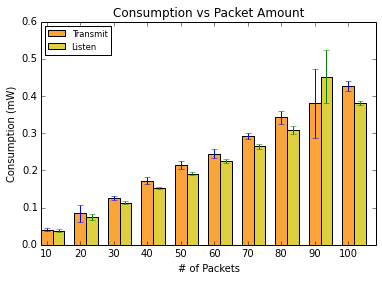

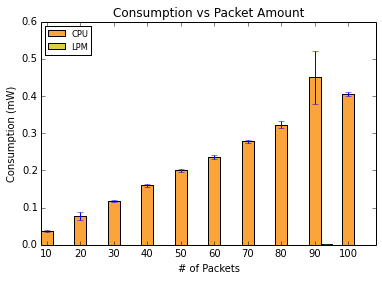

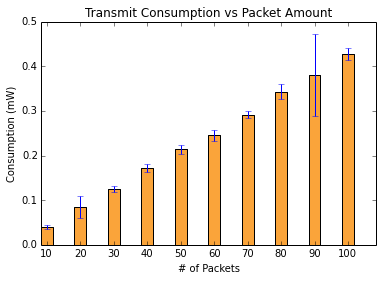

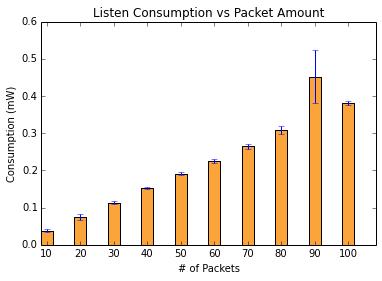

In [19]:
amount_labels = ('10', '20', '30','40','50','60', '70', '80','90','100')
cpu,lpm,tx,rx,std_cpu,std_lpm,std_tx,std_rx,tests = totalConsumptionNew(['logs/log_amount_5times.txt'])

mk_2bar_plot_std(tx[0:10],rx[0:10],amount_labels,std_tx[0:10],std_rx[0:10],0,'# of Packets','Consumption vs Packet Amount')
mk_2bar_plot_std(cpu[0:10],lpm[0:10],amount_labels,std_cpu[0:10],std_lpm[0:10],1,'# of Packets','Consumption vs Packet Amount')
mk_bar_plot_std(tx[0:10],amount_labels, std_tx[0:10], 'Transmit','# of Packets','Transmit Consumption vs Packet Amount')
mk_bar_plot_std(rx[0:10],amount_labels, std_rx[0:10], 'Listen' ,'# of Packets','Listen Consumption vs Packet Amount')

### Power consumption in correlation to interval between sent packets

**Purpose:** The purpose of this experiment is to determine how well the TWAMP test session scales with the time elasped between each sent packet between the **Sender** and the **Reflector**.

**Setup:** 
* The measurements are done on the **Sender**. 
* The distance between **Sender** and **Reflector** was 40 cm.
* The number of packets sent were set to 15.
* The size of the packets sent were 42 octets

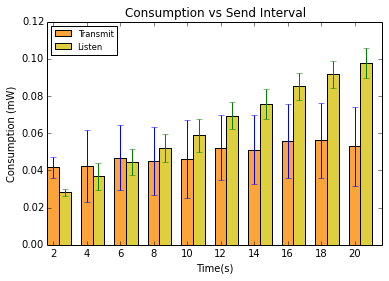

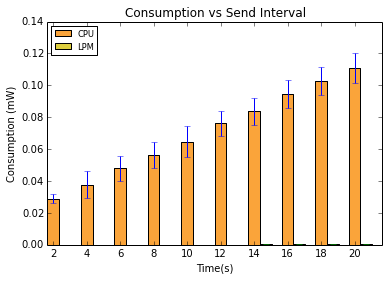

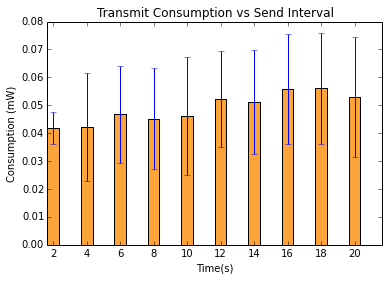

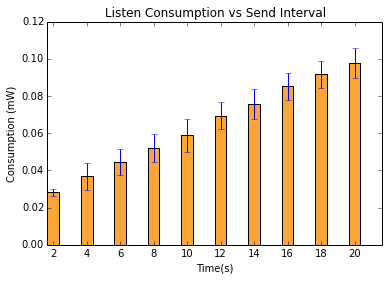

In [20]:
time_labels = ('2', '4','6','8','10','12','14','16','18','20')
cpu,lpm,tx,rx,std_cpu,std_lpm,std_tx,std_rx,tests = totalConsumptionNew(['logs/log_time_25times.txt'])

mk_2bar_plot_std(tx[0:10],rx[0:10],time_labels,std_tx[0:10],std_rx[0:10],0,'Time(s)','Consumption vs Send Interval')
mk_2bar_plot_std(cpu[0:10],lpm[0:10],time_labels,std_cpu[0:10],std_lpm[0:10],1,'Time(s)','Consumption vs Send Interval')
mk_bar_plot_std(tx[0:10],time_labels, std_tx[0:10], 'Transmit','Time(s)','Transmit Consumption vs Send Interval')
mk_bar_plot_std(rx[0:10],time_labels, std_rx[0:10], 'Listen' ,'Time(s)','Listen Consumption vs Send Interval')

### Power consumption in correlation to packet size

**Purpose:** The purpose of this experiment is to determine how well the TWAMP test session scales with the size of the packets. This could be interesting because TWAMP uses quite different packet sizes when sending packets in unauthenticated vs authenticated.

**Setup:** 
* The measurements are done on the **Sender**. 
* The distance between **Sender** and **Reflector** was 40 cm.
* The number of packets sent were set to 15.
* The send interval between the packets were 20 seconds.
* The size of the packets sent were variable.

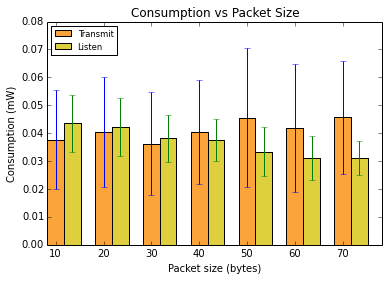

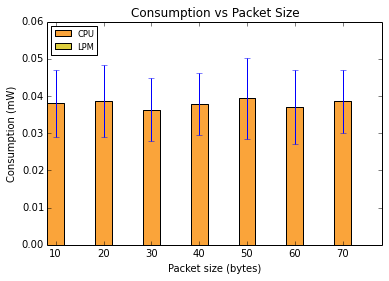

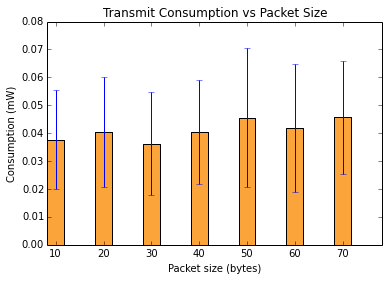

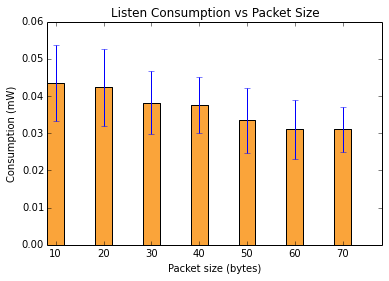

In [21]:
size_labels = ('10','20','30','40','50','60','70')
cpu,lpm,tx,rx,std_cpu,std_lpm,std_tx,std_rx,tests = totalConsumptionNew(['logs/log_size_25times.txt'])

mk_2bar_plot_std(tx[0:7],rx[0:7],size_labels,std_tx[0:7],std_rx[0:7],0,'Packet size (bytes)','Consumption vs Packet Size')
mk_2bar_plot_std(cpu[0:7],lpm[0:7],size_labels,std_cpu[0:7],std_lpm[0:7],1,'Packet size (bytes)','Consumption vs Packet Size')
mk_bar_plot_std(tx[0:7],size_labels, std_tx[0:7], 'Transmit','Packet size (bytes)','Transmit Consumption vs Packet Size')
mk_bar_plot_std(rx[0:7],size_labels, std_rx[0:7], 'Listen' ,'Packet size (bytes)','Listen Consumption vs Packet Size')

### Drift over time between Sender and Reflector

**Purpose:** The purpose of this experiment is to determine how much the Z1 motes drift after they have been synched to the same clock. This would be interesting since it would determine how often the motes would have to be resynched.

**Setup:** 
* The measurements are done on the **Sender** and the **Reflector**. 
* The distance between **Sender** and **Reflector** was 20 cm.
* One synchronization message was sent for the duration of the experiment, this was sent at the start.
* There was a total of 40 packets sent, excluding the synchronization message.
* Packets were sent at a fixed interval, this interval was 30 seconds.
* The size of the packets sent were 42 octets

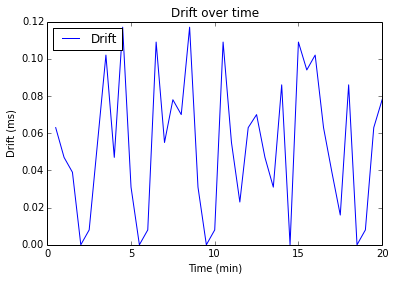

In [22]:
plot_drift('logs/drift20m.txt')

**Results:** We were quite suprised to see that the motes didn't drift more than ~0.1 ms apart with just one synchronization message. Granted this was just over a 20 minute period so it would be interesting to so how much they drift over say a week.

### Average round trip time in correlation to packet size

**Setup:** 
* The measurements are done on the **Sender** and the **Reflector**. 
* The distance between **Sender** and **Reflector** was 30 cm.
* One synchronization message was sent for the duration of the experiment, this was sent at the start.
* There was a total of 20 packets sent, excluding the synchronization message.
* Packets were sent at a fixed interval, this interval was 30 seconds.
* The size of the packets sent were variable.

An average was then taken over the 20 packets sent for each size.

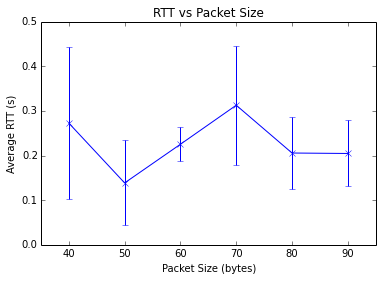

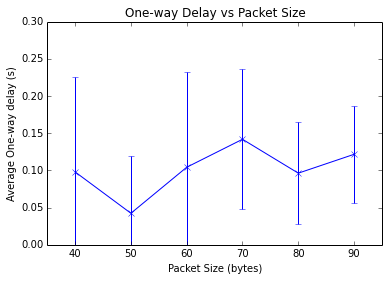

In [23]:
rtt,oneway,std_rtt,std_oneway = extract_rtt('logs/log_rtt_size.txt')

x = [40,50,60,70,80,90]

plot_rtt(x,rtt,std_rtt,"RTT vs Packet Size","Packet Size (bytes)","Average RTT (s)",[35,95,0,0.5])
plot_rtt(x,oneway,std_oneway,"One-way Delay vs Packet Size","Packet Size (bytes)","Average One-way delay (s)",[35,95,0,0.3])

### Average round trip time in correlation to distance

**Setup:** 
* The measurements are done on the **Sender** and the **Reflector**. 
* The distance between **Sender** and **Reflector** was variable.
* One synchronization message was sent for the duration of the experiment, this was sent at the start.
* There was a total of 20 packets sent, excluding the synchronization message.
* Packets were sent at a fixed interval, this interval was 30 seconds.
* The size of the packets sent was 42 bytes.

An average was then taken over the 20 packets sent for each size.

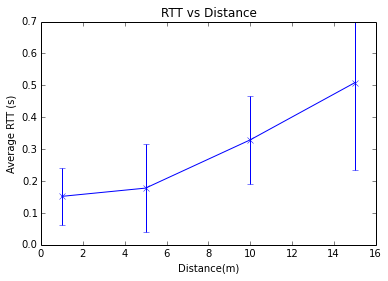

In [28]:
rtt,oneway,std_rtt,std_oneway = extract_rtt('logs/log_rtt_distance_new2.txt')

x = [1,5,10,15]

plot_rtt(x,rtt,std_rtt,"RTT vs Distance","Distance(m)","Average RTT (s)",[0,16,0,0.7])
#plot_rtt(x,oneway,std_oneway,"One-way Delay vs Distance","Distance(m))","Average One-way delay (s)",[0,16,0,1.2])